## This notebook will construct the nodes and edges that we will build our graph with

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/current_clean_spectrum.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [3]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=42, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [4]:
weights['widths']

array([ 83.06058777,  30.22791037, 117.39995528, 102.23322616,
        49.12081416,  91.83065842,  89.33430602])

In [5]:
print(len(peaks))

39808


Below shows a scatterplot of the coordinates of all the peaks we have found

<AxesSubplot: xlabel='WaveNumber', ylabel='Absorbance'>

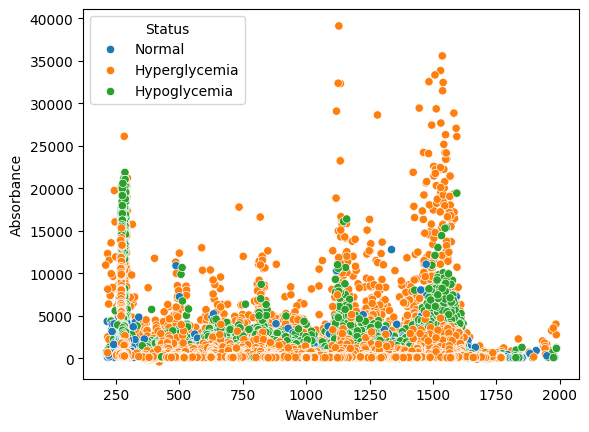

In [6]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [7]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_3719/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_3719/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [8]:
peak_df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences
610,201210-1-00,610,616.85651,201210-1,Normal,177.526558,55.746535,130.700254
726,201210-1-00,726,696.12756,201210-1,Normal,197.599598,55.192611,195.409096
1020,201210-1-00,1020,897.03870,201210-1,Normal,110.427547,116.241928,106.873377
1177,201210-1-00,1177,1004.32800,201210-1,Normal,100.679985,85.871602,83.182554
1817,201210-1-00,1817,1441.68570,201210-1,Normal,75.998964,61.267839,67.332004
...,...,...,...,...,...,...,...,...
8008513,210526-3-49,748,711.16174,210526-3,Hyperglycemia,81.364067,117.399955,74.499646
8008716,210526-3-49,951,849.88611,210526-3,Hyperglycemia,55.964135,102.233226,43.962509
8008937,210526-3-49,1172,1000.91110,210526-3,Hyperglycemia,69.132921,49.120814,60.779406
8009313,210526-3-49,1548,1257.85880,210526-3,Hyperglycemia,55.877277,91.830658,42.124727


We then use the function to assign each peak we have found to a grid slot. We have speicified the slot sizes as they give a meaningful overlap to build our graph

In [9]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [10]:
# Set the size of the grid slots
WaveNumber_slot_size = 200
Absorbance_slot_size = 50

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

/tmp/ipykernel_3719/916937857.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [11]:
peak_df['GridSlot'].nunique()

1473

In [12]:
peak_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences,GridSlot
610,201210-1-00,610,616.85651,201210-1,Normal,177.526558,55.746535,130.700254,"(3, 3)"
726,201210-1-00,726,696.12756,201210-1,Normal,197.599598,55.192611,195.409096,"(3, 3)"
1020,201210-1-00,1020,897.03870,201210-1,Normal,110.427547,116.241928,106.873377,"(4, 2)"
1177,201210-1-00,1177,1004.32800,201210-1,Normal,100.679985,85.871602,83.182554,"(5, 2)"
1817,201210-1-00,1817,1441.68570,201210-1,Normal,75.998964,61.267839,67.332004,"(7, 1)"


We will use "Node_ID" to find distances between peaks later on for our edge construction

In [13]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_3719/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [14]:
peak_df = peak_df.drop(columns=['Seq', 'SurID'])

Here we join the peak dataframe with itself in order to match peaks within the same Spectra Sample

In [15]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))
same_sample['LINK:TYPE'] = 'SAMPLE'

In [16]:
same_sample.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,610,SAMPLE
1,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,726,SAMPLE
2,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,1020,SAMPLE
3,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,1177,SAMPLE
4,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,1817,SAMPLE


We then join the dataframe with itself again, this time to match peaks in the same grid slot

In [17]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))
same_grid_slot['LINK:TYPE'] = 'GRID'

In [18]:
same_grid_slot.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,610,GRID
1,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,726,GRID
2,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,3253,GRID
3,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,5998,GRID
4,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610,11267,GRID


We the combine these new dataframes together to form our relationship dataframe and we perform some clean to get rid of columns we don't need and renaming columns to get them ready for neo4j

In [19]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

In [20]:
del same_sample
del same_grid_slot

In [21]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])

In [22]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})

In [23]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE
0,610,610,SAMPLE
1,610,726,SAMPLE
2,610,1020,SAMPLE
3,610,1177,SAMPLE
4,610,1817,SAMPLE


This gets rid of relationships that match nodes to themselves

In [24]:
graph_df = graph_df[graph_df[':START_ID'] != graph_df[':END_ID']]

We make use of built in numpy functions to efficiently calculate distances between all of our relationships

In [25]:
wave = peak_df['WaveNumber']
absorb = peak_df['Absorbance']

src_indices = graph_df[':START_ID'].values
dst_indices = graph_df[':END_ID'].values

src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

distances = np.linalg.norm(src_coords - dst_coords, axis=1)

dist = distances.tolist()

In [26]:
graph_df['DIST'] = dist

In [27]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST
1,610,726,SAMPLE,81.773017
2,610,1020,SAMPLE,288.104732
3,610,1177,SAMPLE,395.018419
4,610,1817,SAMPLE,831.054177
5,610,2084,SAMPLE,1010.462120


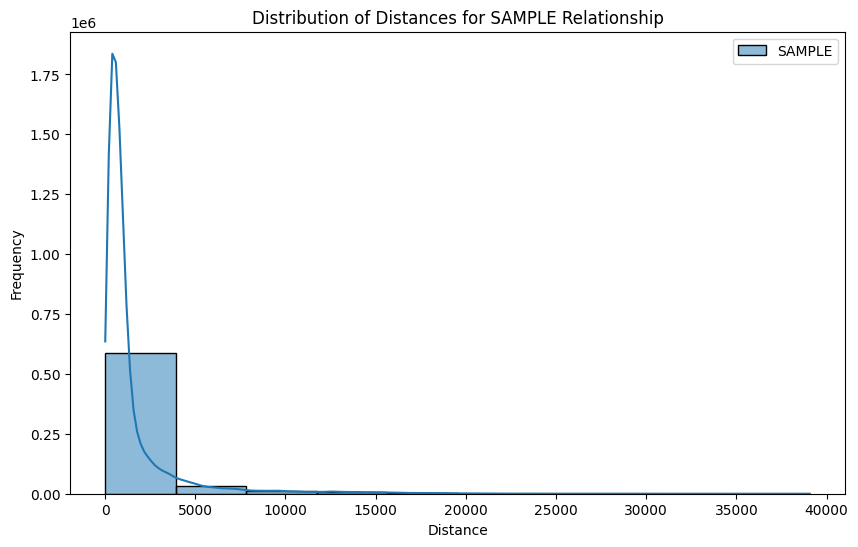

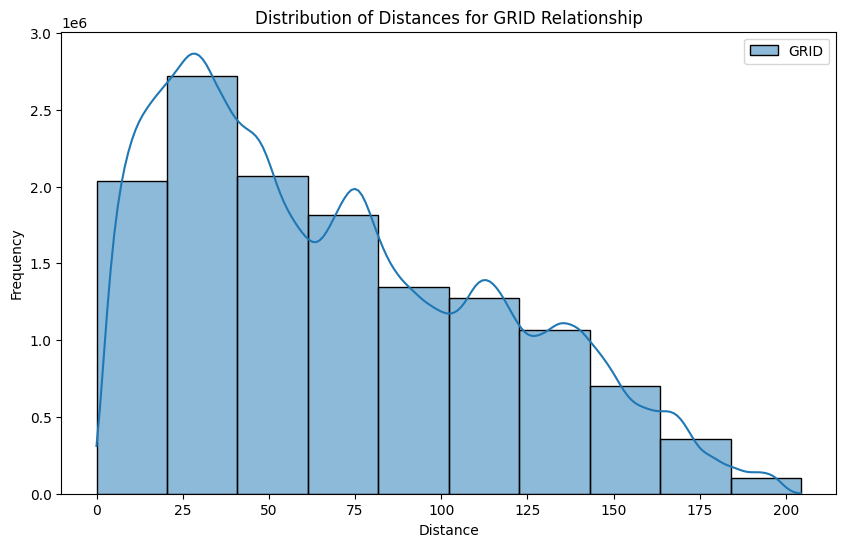

/tmp/ipykernel_3719/2862616078.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
/tmp/ipykernel_3719/2862616078.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])


In [28]:
from sklearn.preprocessing import MinMaxScaler

sample_data = graph_df[graph_df['LINK:TYPE'] == 'SAMPLE']
grid_data = graph_df[graph_df['LINK:TYPE'] == 'GRID']

# Plot histogram for SAMPLE relationship
plt.figure(figsize=(10, 6))
sns.histplot(sample_data["DIST"], bins=10, kde=True, label="SAMPLE")
plt.title("Distribution of Distances for SAMPLE Relationship")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot histogram for GRID relationship
plt.figure(figsize=(10, 6))
sns.histplot(grid_data["DIST"], bins=10, kde=True, label="GRID")
plt.title("Distribution of Distances for GRID Relationship")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

scaler = MinMaxScaler()

sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])

scaled_df = pd.concat([sample_data, grid_data])

In [29]:
scaled_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

In [30]:
scaled_df

,:START_ID,:END_ID,LINK:TYPE,DIST:float
1,610,726,SAMPLE,0.998205
2,610,1020,SAMPLE,0.992923
3,610,1177,SAMPLE,0.990185
4,610,1817,SAMPLE,0.979022
5,610,2084,SAMPLE,0.974428
...,...,...,...,...
14217589,6898530,7011834,GRID,0.827218
14217590,6898530,7014469,GRID,0.879181
14217591,6898530,6895894,GRID,0.812176
14217606,7082986,7096157,GRID,0.939081


In [31]:
scaled_df.to_csv("../../data/graph_1_8/relationships.csv", index=False)

Finally, we clean and rename columsn in our main node dataframe to get it ready for neo4j

In [32]:
peak_df

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID
610,201210-1-00,616.85651,Normal,177.526558,55.746535,130.700254,"(3, 3)",610
726,201210-1-00,696.12756,Normal,197.599598,55.192611,195.409096,"(3, 3)",726
1020,201210-1-00,897.03870,Normal,110.427547,116.241928,106.873377,"(4, 2)",1020
1177,201210-1-00,1004.32800,Normal,100.679985,85.871602,83.182554,"(5, 2)",1177
1817,201210-1-00,1441.68570,Normal,75.998964,61.267839,67.332004,"(7, 1)",1817
...,...,...,...,...,...,...,...,...
8008513,210526-3-49,711.16174,Hyperglycemia,81.364067,117.399955,74.499646,"(3, 1)",8008513
8008716,210526-3-49,849.88611,Hyperglycemia,55.964135,102.233226,43.962509,"(4, 1)",8008716
8008937,210526-3-49,1000.91110,Hyperglycemia,69.132921,49.120814,60.779406,"(5, 1)",8008937
8009313,210526-3-49,1257.85880,Hyperglycemia,55.877277,91.830658,42.124727,"(6, 1)",8009313


In [33]:
peak_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

In [34]:
peak_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)

In [35]:
peak_df.to_csv('../../data/graph_1_8/nodes.csv', index=False)